In [1]:
# If memory/processing speed becomes an issue, may need to launch Jupyter from terminal with 
# "jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000"

# Necessary imports:

import imageio
import itertools
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np
import seaborn as sns

from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
from scipy import ndimage, misc, stats
from scipy.misc import imsave
from scipy.ndimage.filters import minimum_filter
from matplotlib.font_manager import FontProperties
from sklearn.mixture import GMM
from sklearn.cluster import KMeans

# http://zulko.github.io/moviepy/
from moviepy.editor import *
import pygame
%matplotlib inline
imageio.plugins.ffmpeg.download()

In [2]:
### Style ###

# set graph size:
size = (6, 3.5)

# set distance between header and top of graph
header_space = 0.88 

In [3]:
# RGB to grayscale function:
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [6]:
# Create a list of video files to score.
# VIDEOS MUST FIRST BE STORED IN YOUR JUPYTER ENVIRONMENT!

video_files = [VideoFileClip("paprika1.mov"), VideoFileClip("paprika2.mov"), VideoFileClip("paprika3.mov")]

194
148
242


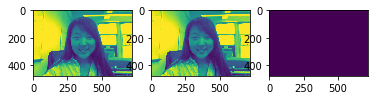

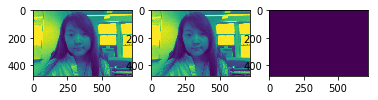

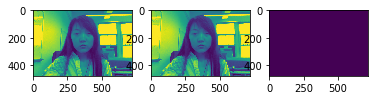

In [8]:
sum_sq_diff_list = []

r_squared_values_list = []

# Loop over each video to be scored:
for video in video_files:
    sum_sq_diff = []
    r_squared_values = []
    #pearson = []
    prev_frame = []
    total_frames = 0
    
    # Within each video, loop over individual frames, comparing each frame to its preceding frame:
    for frame in video.iter_frames(fps=30):
        this_frame = rgb2gray(frame)
        if prev_frame != []:
            total_frames += 1
            
            # Get the delta between contiguous frames:
            diff_frame = this_frame-prev_frame
            r_squared = (np.corrcoef(np.ravel(this_frame), np.ravel(prev_frame))[0,1])**2
            r_squared_values.append(r_squared)
            
            # Square each delta to eliminate negative values:
            diff_frame_sq = np.power(diff_frame, 2)
            sum_diff_frame_sq = np.sum( diff_frame_sq )
            sum_sq_diff.append( sum_diff_frame_sq )
            
            # Get the r-squared (or Pearson's) correlation coefficient between each frame:
            # ::: Do something to diff_frame to get this value; store that value a float variable :::
            # ::: Append the value to the "pearson = []" list :::
            
        prev_frame = this_frame
        
    # Append the full list of squared deltas to a master list of 
    # squared deltas for each of the n videos to be scored:
    sum_sq_diff_list.append(sum_sq_diff)
    r_squared_values_list.append(r_squared_values)
    print (total_frames)
    
    # Plot some contiguous frames and delta frames from each video:
    f, axarr = plt.subplots(1,3)
    axarr[0].imshow(this_frame)
    axarr[1].imshow(prev_frame)
    axarr[2].imshow(diff_frame)

Outlying value -0.006456997228639165 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.005760761316942947 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.005587714703302356 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.005582803399344155 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.005439805609242241 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.005439631890861129 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.007844976774944246 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.0067572108313594635 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.006945879301598661 has been replaced with 0 in Video 1's log-transformed normalized data.
Outlying value -0.008196074

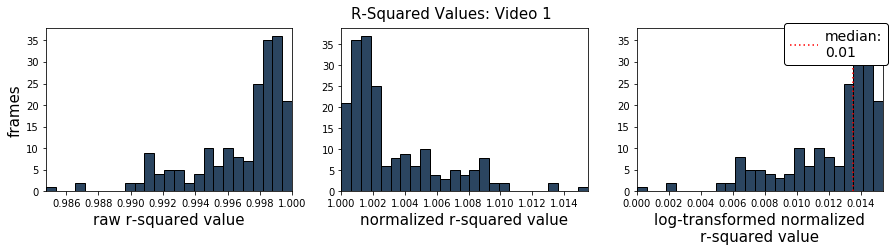

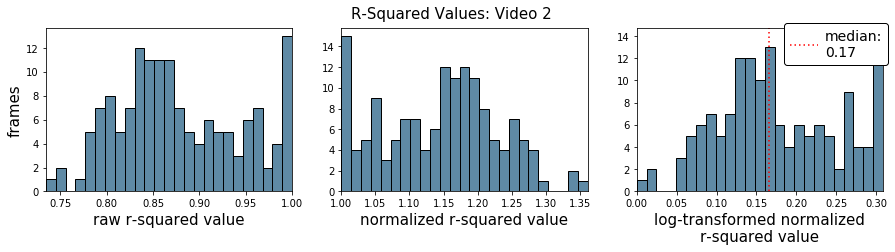

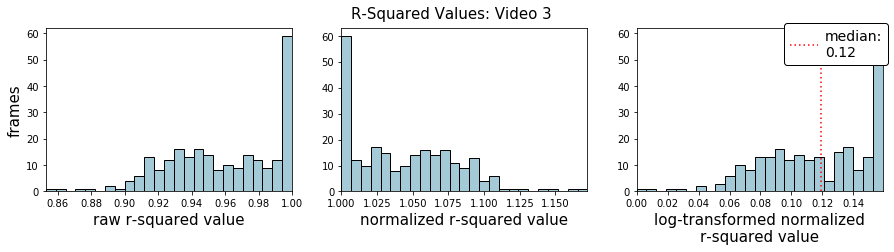

In [22]:
###PLOT AND STORE RAW, NORMALIZED, AND LOG-TRANSFORMED/NORMALIZED R-SQUARED VALUES ###

palette = sns.cubehelix_palette(n_colors = len(r_squared_values_list), start = 2.8, rot = -.1, dark = .25, light = .75, reverse = True)

count = 0

normalized_r2_values = []
log_transformed_normalized_r2_values = []
outliers_list = []

# Iterate over the list of lists of r-squared values:
for values in r_squared_values_list:
    
    temp_normalized_values = []
    temp_log_transformed_normalized_values = []
    
    # Iterate over each r-squared value, to get/store normalized and log-transformed/normalized values:
    for value in values:
        
        ##trying different normalize get
        norm_value = (1/value)
        temp_normalized_values.append(norm_value)
        
        # Get log-transformed normalized values:
        log_transformed = np.log(value) # Constant added to avoid negative values
        if np.isfinite(log_transformed) == True:
            temp_log_transformed_normalized_values.append(log_transformed)
        else:
            temp_log_transformed_normalized_values.append(0)
    
    # We are getting a few extreme outliers in the temp_log_transformed_normalized_values list.
    # These outliers are skewing our graphs, so we have done some manipulations to eliminate them 
    # using relative absolute distance from the median. This way, the filter will work for any inputs:
    
    log_median = np.median(temp_log_transformed_normalized_values)
        
    # Iterate over each value in temp_log_transformed_normalized_values and calculate/store the absolute
    # distance from the median for each:
    log_abs_dists = []
    for log in temp_log_transformed_normalized_values:
        dist = abs(log - log_median)
        log_abs_dists.append(dist)
        
    log_median_abs_dist = np.median(log_abs_dists)
            
    # Iterate over each value in temp_log_transformed_normalized_values and check to see whether it's an outlier.
    # If it is an outlier, change the value to zero. If not, pass.
    outliers = []
    count_2 = 0    
    for i in temp_log_transformed_normalized_values:
        sensitivity = 3 # A smaller value will capture more outliers; large values assume large "spread"
        if abs(i) > abs(log_median) + (sensitivity * log_median_abs_dist):
            outliers.append(i)
            print ("Outlying value {} has been replaced with 0 in Video {}'s log-transformed normalized data."
            .format(i, count + 1))
        else:
            pass
        count_2 += 1

    outliers_list.append(outliers)
    
    # Plot histograms of the normalized r-squared values:
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 3), sharex=False, sharey=False, subplot_kw={'adjustable': 'box-forced'})
    fig.suptitle('R-Squared Values: Video {}'.format(count + 1), fontsize=15)
    ax = axes.ravel()

    # Unadjusted r-squared scores:
    ax[0].set_ylabel('frames', fontsize = 15)
    ax[0].set_xlabel('raw r-squared value', fontsize = 15)
    ax[0].hist(values, edgecolor = "black", bins=25, color = palette[count]);
    ax[0].set_ylim(bottom=0)
    ax[0].set_xlim(left=min(values), right=max(values))

    # Normalized r-squared scores:
    ax[1].set_xlabel('normalized r-squared value', fontsize = 15)
    ax[1].hist(temp_normalized_values, edgecolor = "black", bins=25, color = palette[count]);
    ax[1].set_ylim(bottom=0)
    ax[1].set_xlim(left=min(temp_normalized_values), right=max(temp_normalized_values))
    
    # Log-transformed r-squared scores:
    plot_me = temp_log_transformed_normalized_values - min(temp_log_transformed_normalized_values)
    #print np.median
    ax[2].set_xlabel('log-transformed normalized\nr-squared value', fontsize = 15)
    ax[2].hist(plot_me, edgecolor = "black", bins=25, color = palette[count]);
    ax[2].set_ylim(bottom=0)
    ax[2].set_xlim(left=0, right=max(plot_me))
    ax[2].axvline(x = np.median(plot_me), c = "r", dashes = [1, 2], label = "median:\n{:.2f}".format(np.median(plot_me)))
    ax[2].legend(bbox_to_anchor=(1.02, 1.03), loc="upper right", borderaxespad=0., fontsize = 14, frameon=True, framealpha=1, edgecolor = "inherit", handletextpad=.5)
    
    # Store each list of normalized r-squared values outside the loop for later use:
    #normalized_r2_values.append(temp_normalized_values)
    log_transformed_normalized_r2_values.append(plot_me)
        
    count += 1